## Capstone Project

## Machine Learning Model Development to Detect Black Hole Nodes in an AODV network.


This Jupyter Notebook script loaded the training and test datasets that were created from running NS-3 network simulations that simulated AODV networks with black hole nodes that disrupt communication by capturing network data and discarding it rather than passing it along to the correct destination node. 

The NS-3 simulation produced .pcap network traces for each node. all of these individual node trace files were imported into a script developed for this project that converted the AODV message observed in the nodes into a dataset with features that can be used to detect black hole nodes. These individual dataset were merged together into one large data set for each network simulation. 

**X amount of** simulations were merged together to form the training dataset and each additional network simulation can be used as a testing dataset. 

These models can be used to detect which nodes are acting as a black hole node within the network.

## 1. Importing the datasets

The train and test .csv files are loaded.
As the data can be very easily produced from network simulations, data collection is not an issue and so the data is not split into training and test sets, instead the training and the test data are separate network simulations.

<span style="color: red;">Talk about the size of the training dataset, how many network sims combined?</span>
<span style="color: red;">How many sims should we use?</span>

In [3]:
# Read in the train and test sets
train =  pd.read_csv('./Datasets/train2_BHN.csv', index_col=0)
test = pd.read_csv('./Datasets/test3_BHN.csv', index_col=0)

## 2. Exploring the Data

In [ ]:
# Install profiling packages if not available
!pip install ydata-profiling

- Run data profiling on train and test data to provide detailed report on .html files. 
- Summary from these report will inform the next step for data processing and modeling
- View the `train_data_profiling_report.html` and `test_data_profiling_report.html` to see the profiling reports

In [ ]:
from ydata_profiling import ProfileReport
train_profile = ProfileReport(train, title="Train Data Profiling Report")
train_profile.to_file("train_data_profiling_report.html")


test_profile = ProfileReport(test, title="Test Data Profiling Report")
test_profile.to_file("test_data_profiling_report.html")

# 3. Analyse train data

#### Recommendation 1:  Remove columns with constant values. 

`Nbr_Is_Dest_Cnt` and `Nbr_Never_Dest` columns has constant values, it is recommended to remove from the `train` and `test` dataset before further processing 

In [16]:
print(f"All the values of 'Nbr_Is_Dest_Cnt' from the training data: {set(train['Nbr_Is_Dest_Cnt'])}")

All the values of 'Nbr_Is_Dest_Cnt' from the training data: {0}


In [17]:
print(f"All the values of 'Nbr_Never_Dest' from the training data: {set(train['Nbr_Never_Dest'])}")

All the values of 'Nbr_Never_Dest' from the training data: {True}


#### Recommendation 2: 

Remove Index columns or ID columns 
`Index`  has unique values, it is required to remove from the datasets

In [23]:
print(f"Total of unique values from 'Index' columns: {len(set(train['Index']))}")

Total of unique values from 'Index' columns: 659


In [24]:
print(f"Length of traind dataset: {len(train)}")

Length of traind dataset: 659


#### Recommendation 3: Handle imbalanced data
- `Black_Hole_Node` is a `target variable` and it is highly imbalanced (66.4%), it is recommended to handle imbalance data on modeling step

In [29]:
train.groupby("Black_Hole_Node").count()[["Index"]].reset_index().rename(columns={"Index":"Count"})

,Black_Hole_Node,Count
0,False,618
1,True,41


#### Recommendation 4: Handle missing values

The following missing values are recommended to impute during modeling process 

- Hop_Cnt_Over_1_Pct has 235 (35.7%) missing values
- High_Dest_Seq_Num_Inc_Pct has 235 (35.7%) missing values
- Avg_Resp_Dly has 246 (37.3%) missing values	
- Avg_Resp_Dly_Per_Hop has 246 (37.3%) missing values	
- RERRs_From_Nbr_Pct has 235 (35.7%) missing values	


In [38]:
def print_missing_values(col):
        print(f"{col} has {train['Hop_Cnt_Over_1_Pct'].isna().sum()} ({round(train['Hop_Cnt_Over_1_Pct'].isna().sum()/len(train)*100,1)}%) missing values")
        
for col in ["Hop_Cnt_Over_1_Pct",
            "High_Dest_Seq_Num_Inc_Pct",
            "Avg_Resp_Dly",
            "Avg_Resp_Dly_Per_Hop",
            "RERRs_From_Nbr_Pct"]:
    print_missing_values(col)


Hop_Cnt_Over_1_Pct has 235 (35.7%) missing values
High_Dest_Seq_Num_Inc_Pct has 235 (35.7%) missing values
Avg_Resp_Dly has 235 (35.7%) missing values
Avg_Resp_Dly_Per_Hop has 235 (35.7%) missing values
RERRs_From_Nbr_Pct has 235 (35.7%) missing values


#### Recommendation 5: Review highly correlated features to the target variables

- These indicators are highly correlated with the target variable using either `pearson` or `spearman` correlation metric:
            'RREPs_From_Nbr',
            'RREP_Resp_Pct',
            'Pct_Of_All_RREPs',
            'Hop_Cnt_Over_1_Cnt',
            'Hop_Cnt_Over_1_Pct',
            'High_Dest_Seq_Num_Inc_Cnt',
            'High_Dest_Seq_Num_Inc_Pct',
            'RREP_To_Nbrs_Ratio'
            
- It is required to understand the context of these variables to make sure <br>
(1) they are correctly correlated and <br>
(2) they are not create data leaking during modeling

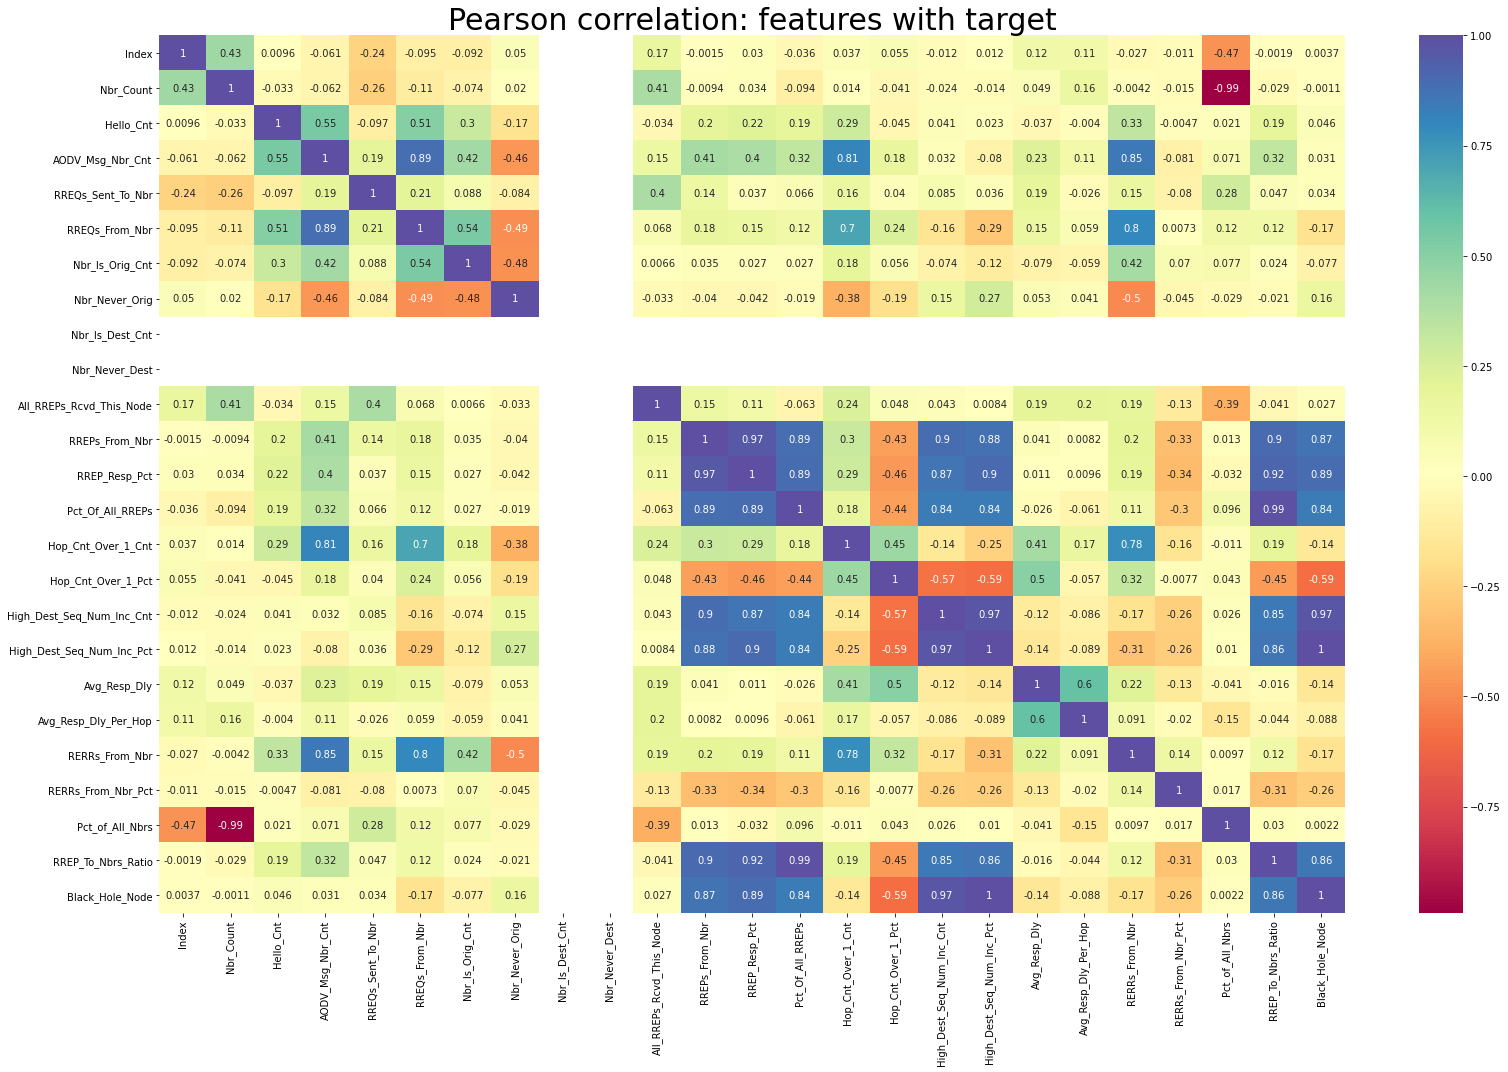

In [86]:
import seaborn as sns
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(train.corr(method="pearson"), annot=True, cmap='Spectral', annot_kws={'fontsize': 10});
plt.title('Pearson correlation: features with target', fontsize=30)
plt.show()


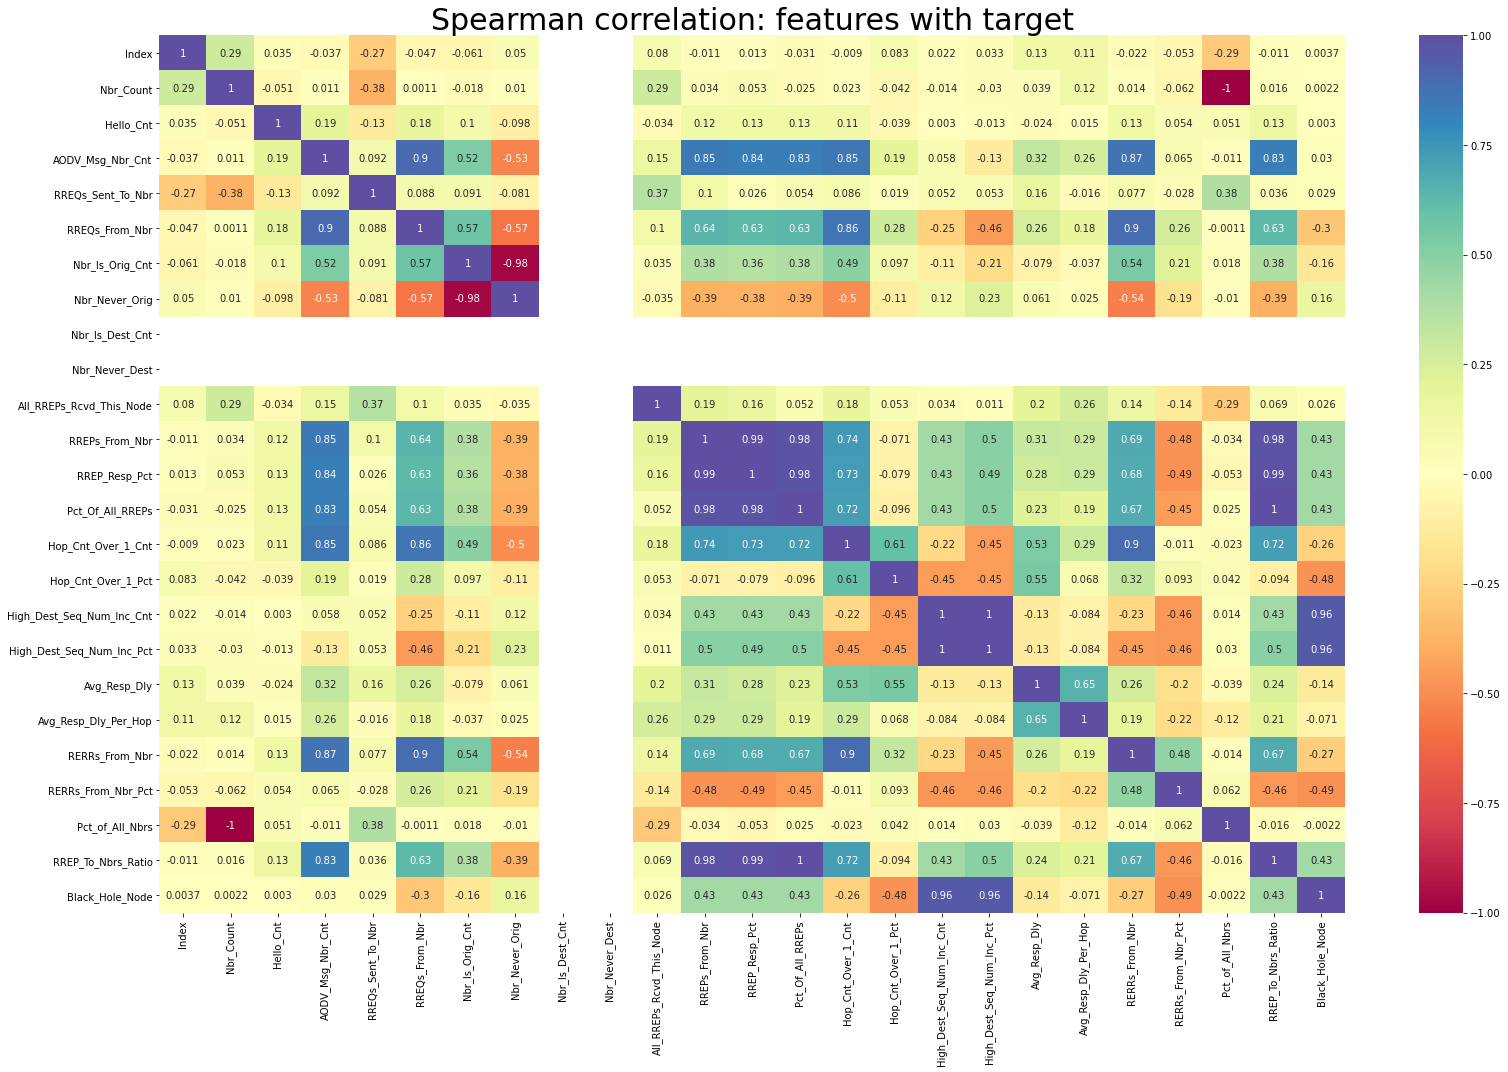

In [87]:
plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(train.corr(method="spearman"), annot=True, cmap='Spectral', annot_kws={'fontsize': 10});
plt.title('Spearman correlation: features with target', fontsize=30)
plt.show()


#### Recommendation 6: Consider to trim highly correlation indicators

- Some of the indicators that are highly correlated, it is recommended to review them and select the good one during feature selection process


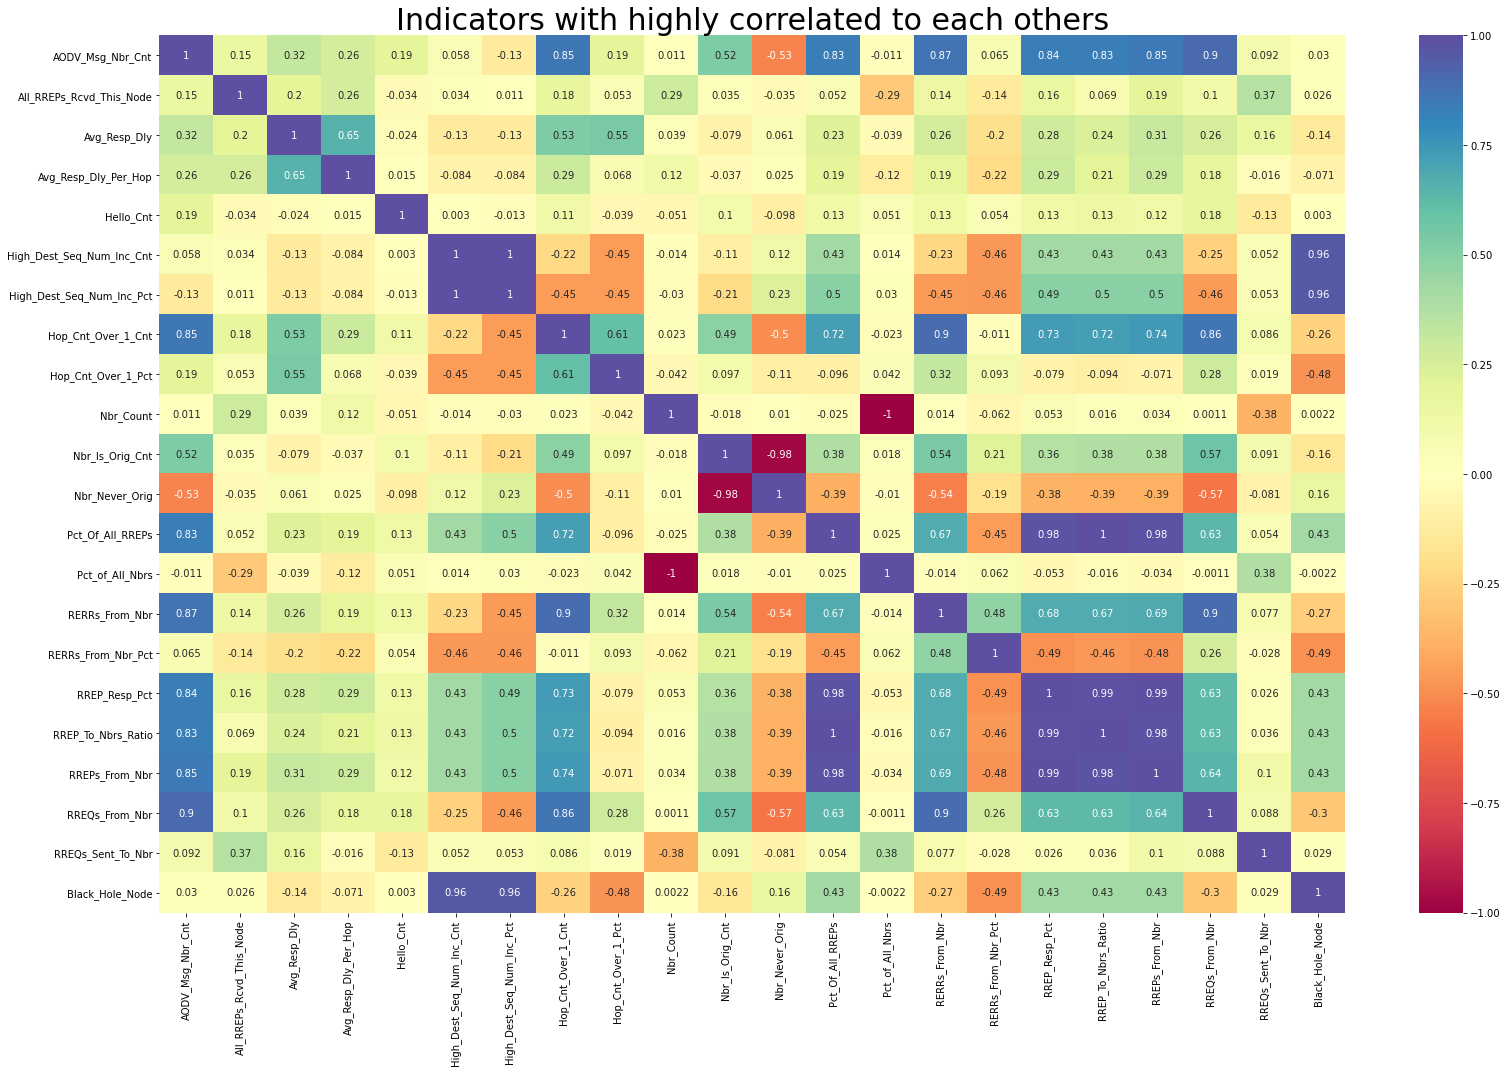

In [90]:
import seaborn as sns
cols = [
 'AODV_Msg_Nbr_Cnt',
 'All_RREPs_Rcvd_This_Node',
 'Avg_Resp_Dly',
 'Avg_Resp_Dly_Per_Hop',
 'Hello_Cnt',
 'High_Dest_Seq_Num_Inc_Cnt',
 'High_Dest_Seq_Num_Inc_Pct',
 'Hop_Cnt_Over_1_Cnt',
 'Hop_Cnt_Over_1_Pct',
 'Nbr_Count',
 'Nbr_Is_Orig_Cnt',
 'Nbr_Never_Orig',
 'Nbr_Node',
 'Node',
 'Pct_Of_All_RREPs',
 'Pct_of_All_Nbrs',
 'RERRs_From_Nbr',
 'RERRs_From_Nbr_Pct',
 'RREP_Resp_Pct',
 'RREP_To_Nbrs_Ratio',
 'RREPs_From_Nbr',
 'RREQs_From_Nbr',
 'RREQs_Sent_To_Nbr',
 'Black_Hole_Node']
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(train[cols].corr(method="spearman"), annot=True, cmap='Spectral', annot_kws={'fontsize': 10})
plt.title('Indicators with highly correlated to each others', fontsize=30)
plt.show()

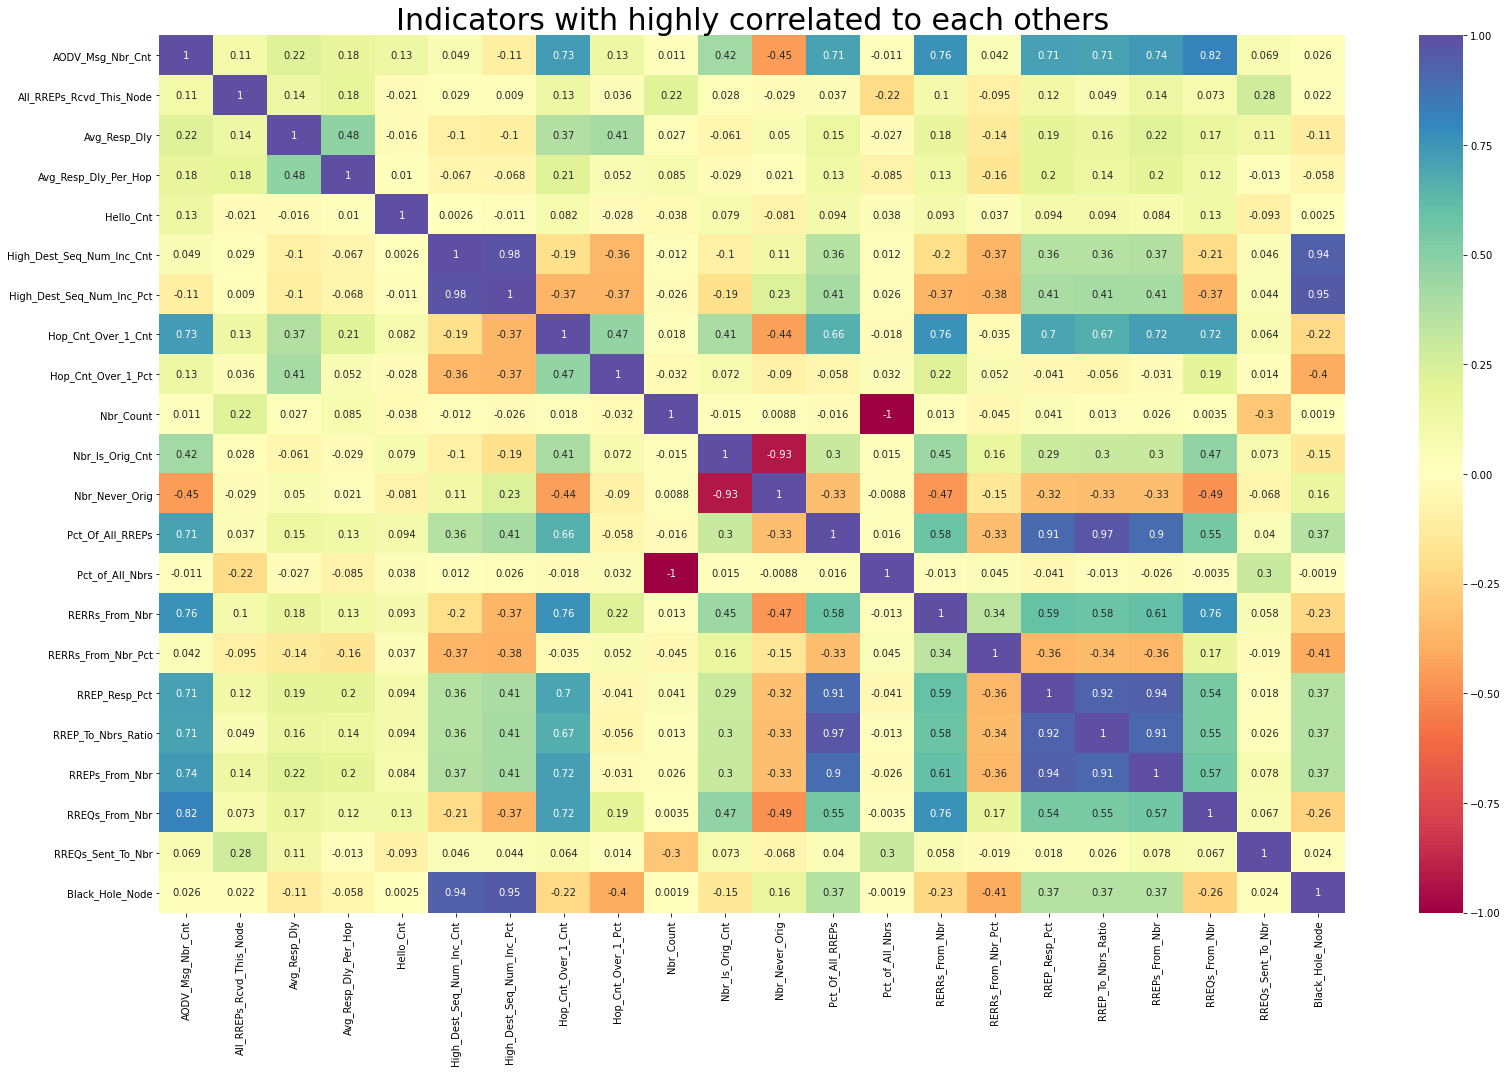

In [105]:
import seaborn as sns
cols = [
 'AODV_Msg_Nbr_Cnt',
 'All_RREPs_Rcvd_This_Node',
 'Avg_Resp_Dly',
 'Avg_Resp_Dly_Per_Hop',
 'Hello_Cnt',
 'High_Dest_Seq_Num_Inc_Cnt',
 'High_Dest_Seq_Num_Inc_Pct',
 'Hop_Cnt_Over_1_Cnt',
 'Hop_Cnt_Over_1_Pct',
 'Nbr_Count',
 'Nbr_Is_Orig_Cnt',
 'Nbr_Never_Orig',
 'Nbr_Node',
 'Node',
 'Pct_Of_All_RREPs',
 'Pct_of_All_Nbrs',
 'RERRs_From_Nbr',
 'RERRs_From_Nbr_Pct',
 'RREP_Resp_Pct',
 'RREP_To_Nbrs_Ratio',
 'RREPs_From_Nbr',
 'RREQs_From_Nbr',
 'RREQs_Sent_To_Nbr',
 'Black_Hole_Node']
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [23, 15]
plt.rcParams["figure.autolayout"] = True
sns.heatmap(train[cols].corr(method="kendall"), annot=True, cmap='Spectral', annot_kws={'fontsize': 10})
plt.title('Indicators with highly correlated to each others', fontsize=30)
plt.show()

#### Recommendation 7: handle categorical features

- These categorical features are required to be transformed (one-hot-encoding) during modeling process

    "Node" <br>
    "Nbr_Node" <br>
    "Nbr_Never_Orig" <br>

#### Recommendation 8: transform numerical features

- Some numerical features are required to normalise (zscore) or changing to normal distribution (power transform such as Yeo–Johnson) to support for modeling
- It is recommended to transform all of these features as a part of modeling
- See some of the typical examples below

<AxesSubplot:>

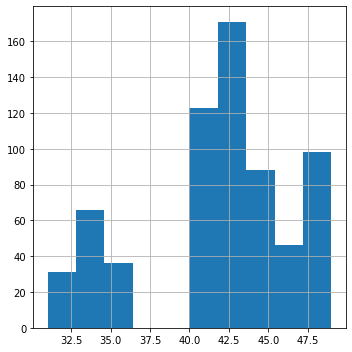

In [97]:
plt.rcParams["figure.figsize"] = [5, 5]
train["Nbr_Count"].hist()

<AxesSubplot:>

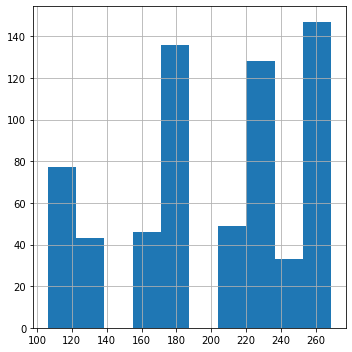

In [99]:
train["RREQs_Sent_To_Nbr"].hist()

<AxesSubplot:>

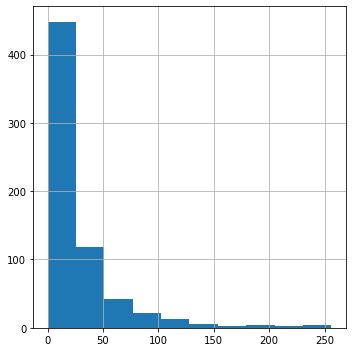

In [100]:
train["RREQs_From_Nbr"].hist()

<AxesSubplot:>

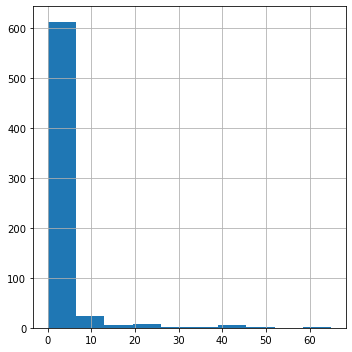

In [101]:
train["Nbr_Is_Orig_Cnt"].hist()

<AxesSubplot:>

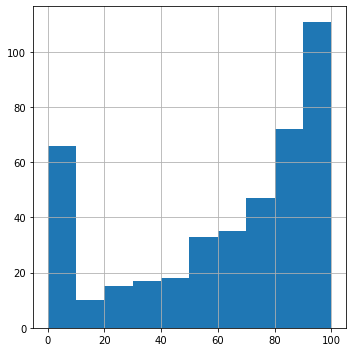

In [103]:
train["Hop_Cnt_Over_1_Pct"].hist()

<AxesSubplot:>

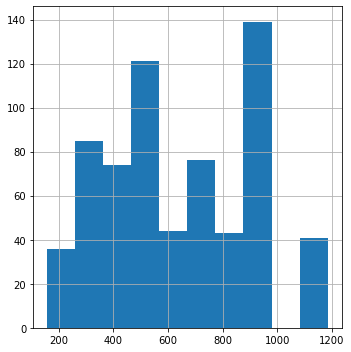

In [102]:

train["All_RREPs_Rcvd_This_Node"].hist()

# 4. Anayse Test data

`Test data` has the similar trend like `train data`